In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import os, glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from skimage.measure import block_reduce
from numpy.lib.stride_tricks import as_strided
plt.style.use([hep.style.ROOT, hep.style.firamath])
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
# Define the CMS color scheme
cms_colors = [
    (0.00, '#FFFFFF'),  # White
    (0.33, '#005EB8'),  # Blue
    (0.66, '#FFDD00'),  # Yellow
    (1.00, '#FF0000')   # red
]

# Create the CMS colormap
cms_cmap = LinearSegmentedColormap.from_list('CMS', cms_colors)
from numpy.lib.stride_tricks import as_strided




Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xjwneex7 because the default path (/uscms/home/bbbam/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def upsample_array(x, b0, b1):
    r, c = x.shape                                    # number of rows/columns
    rs, cs = x.strides                                # row/column strides
    x = as_strided(x, (r, b0, c, b1), (rs, 0, cs, 0)) # view as a larger 4D array
    return x.reshape(r*b0, c*b1)/(b0*b1) # create new 2D array with same total occupancy
    
def resample_EE(imgECAL, factor=2):
    # EE-
    imgEEm = imgECAL[:140-85] # EE- in the first 55 rows
    imgEEm = np.pad(imgEEm, ((1,0),(0,0)), 'constant', constant_values=0) # for even downsampling, zero pad 55 -> 56
    imgEEm_dn = block_reduce(imgEEm, block_size=(factor, factor), func=np.sum) # downsample by summing over [factor, factor] window
    imgEEm_dn_up = upsample_array(imgEEm_dn, factor, factor)/(factor*factor) # upsample will use same values so need to correct scale by factor**2
    imgECAL[:140-85] = imgEEm_dn_up[1:] ## replace the old EE- rows
    # EE+
    imgEEp = imgECAL[140+85:] # EE+ in the last 55 rows
    imgEEp = np.pad(imgEEp, ((0,1),(0,0)), 'constant', constant_values=0) # for even downsampling, zero pad 55 -> 56
    imgEEp_dn = block_reduce(imgEEp, block_size=(factor, factor), func=np.sum) # downsample by summing over [factor, factor] window
    imgEEp_dn_up = upsample_array(imgEEp_dn, factor, factor)# upsample will use same values so need to correct scale by factor*factor
    imgECAL[140+85:] = imgEEp_dn_up[:-1] # replace the old EE+ rows
    return imgECAL



def crop_jet(imgECAL, iphi, ieta, jet_shape=125):

    # NOTE: jet_shape here should correspond to the one used in RHAnalyzer
    off = jet_shape//2
    iphi = int(iphi*5 + 2) # 5 EB xtals per HB tower
    ieta = int(ieta*5 + 2) # 5 EB xtals per HB tower

    # Wrap-around on left side
    if iphi < off:
        diff = off-iphi
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,-diff:],
                                   imgECAL[:,ieta-off:ieta+off+1,:iphi+off+1]), axis=-1)
    # Wrap-around on right side
    elif 360-iphi < off:
        diff = off - (360-iphi)
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,iphi-off:],
                                   imgECAL[:,ieta-off:ieta+off+1,:diff+1]), axis=-1)
    # Nominal case
    else:
        img_crop = imgECAL[:,ieta-off:ieta+off+1,iphi-off:iphi+off+1]

    return img_crop

### Layesrs in images

In [3]:
layers =['TracksAtECAL_pt', 'TracksAtECAL_dZSig', 'TracksAtECAL_d0Sig', 'ECAL_energy', \
         'HBHE_energy', 'PixAtEcal_1','PixAtEcal_2', 'PixAtEcal_3', 'PixAtEcal_4', 'TibAtEcal_1',\
         'TibAtEcal_2', 'TibAtEcal_3','TibAtEcal_4', 'TobAtEcal_1','TobAtEcal_2', 'TobAtEcal_3', \
         'TobAtEcal_4', 'TobAtEcal_5', 'TobAtEcal_6' , 'TidAtEcal_1',\
                                  'TecAtEcal_1', 'TecAtEcal_2', 'TecAtEcal_3']
print("Number of layers", len(layers))


Number of layers 23


### Plotting function

In [4]:
def plotJet_single_layer(img, eve, run):
    # img[np.abs(img) < 1.e-5] = 0 # to rmove noise
    mins = [0.00001]*len(img)
    maxs =[]
    for j in range(len(img)):
         maxs.append(img[j].max())
    # out_dir='plot_for_prelim'
    # if not os.path.isdir(out_dir):
    #     os.makedirs(out_dir)
    for k in range(len(img)):
        
        color = ['Oranges','Blues','Greys','Greens', 'Blues']
        if k<5:
            color_selected = color[k]
        else:
            color_selected = color[2]
            
        if maxs[k]  > 0 : plt.imshow(img[k], cmap=f'{color_selected}', norm=LogNorm(vmin=mins[k], vmax=maxs[k]),  alpha=0.9)
        plt.title(f"{layers[k]} Run {run}")
        plt.xlabel(r"$\mathrm{i\varphi}$") #28, 30
        plt.ylabel(r"$\mathrm{i\eta}$") #28, 30

        # plt.savefig(f'{out_dir}/pixel_1_{eve}_{crop_position}.png',facecolor='w',dpi=300)
        plt.show()
    return img 
def plotJet(img, eve, run):
#     out_dir='plot_for_prelim/Img_A_2Tau_unmerged_dR_1_1p5'
#     if not os.path.isdir(out_dir):
#         os.makedirs(out_dir)
    mins = [0.001]*len(img)
    energy = {2:'13', 3:'13.6'}.get(run)
    maxs =[]
    for i in range(len(img)):
        maxs.append(img[i].max())
    fig, ax = plt.subplots(figsize=(12,12))
    if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
    if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
    if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
    if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.4)   
    if maxs[5]  > 0 : plt.imshow(img[5], cmap='Purples', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
    if maxs[10] > 0 : plt.imshow(img[10], cmap= 'pink',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
    hep.cms.label(llabel=f"Image event number {eve} Run {run}", rlabel=f"{energy} TeV", loc=0, ax=ax)
#     plt.title(f"Image event number {eve} ")
    plt.xlabel(r"$\mathrm{i\varphi}$") #28, 30
    plt.ylabel(r"$\mathrm{i\eta}$") #28, 30
    #LEGEND
    colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
    labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
#     plt.tight_layout()
#     plt.savefig(f'{out_dir}/{eve}_Cropped_Image_event_crop_{crop_position}.png',facecolor='w',dpi=300,)
    plt.show()

### Plot cropped images function

In [5]:

def make_img_eve_cropped(i, run):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    # ECAL_energy = resample_EE(ECAL_energy)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    # ys = ak.Array(branches["jetIsSignal"])[i]
    ys = ak.Array(branches["jetIsDiTau"])[i]
    print(ys)
    iphis  = ak.Array(branches["jetSeed_iphi"])[i]
    ietas  = ak.Array(branches["jetSeed_ieta"])[i]
    for j in range(len(ys)):
        img_cropped = crop_jet(X_CMS, iphis[j], ietas[j], jet_shape=125)
        plotJet(img_cropped, i, run)
        
def make_img_all_layers_cropped(i, run):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    # ECAL_energy = resample_EE(ECAL_energy)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    # ys = ak.Array(branches["jetIsSignal"])[i]
    ys = ak.Array(branches["jetIsDiTau"])[i]
    iphis  = ak.Array(branches["jetSeed_iphi"])[i]
    ietas  = ak.Array(branches["jetSeed_ieta"])[i]
    for j in range(len(ys)):
        img_cropped = crop_jet(X_CMS, iphis[j], ietas[j], jet_shape=125)
        plotJet_single_layer(img_cropped, i, run)   
  

### Plot full image function

In [6]:

def make_img_eve_full(i, run):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    # ECAL_energy = resample_EE(ECAL_energy)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    plotJet(X_CMS, i, run)
        
def make_img_all_layers_full(i, run):
    ECAL_energy = np.array(branches["ECAL_energy"][i]).reshape(280,360)
    # ECAL_energy = resample_EE(ECAL_energy)
    HBHE_energy_ = np.array(branches["HBHE_energy"][i]).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy_, 5, 5) # (280, 360)
    TracksAtECAL_pt = np.array(branches["ECAL_tracksPt_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_dZSig = np.array(branches["ECAL_tracksDzSig_atECALfixIP"][i]).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(branches["ECAL_tracksD0Sig_atECALfixIP"][i]).reshape(280,360)
    PixAtEcal_1        = np.array(branches["BPIX_layer1_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_2        = np.array(branches["BPIX_layer2_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_3        = np.array(branches["BPIX_layer3_ECAL_atPV"][i]).reshape(280,360)
    PixAtEcal_4        = np.array(branches["BPIX_layer4_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_1        = np.array(branches["TIB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_2        = np.array(branches["TIB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_3        = np.array(branches["TIB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TibAtEcal_4        = np.array(branches["TIB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_1        = np.array(branches["TOB_layer1_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_2        = np.array(branches["TOB_layer2_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_3        = np.array(branches["TOB_layer3_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_4        = np.array(branches["TOB_layer4_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_5        = np.array(branches["TOB_layer5_ECAL_atPV"][i]).reshape(280,360)
    TobAtEcal_6        = np.array(branches["TOB_layer6_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_1        = np.array(branches["TEC_layer1_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_2        = np.array(branches["TEC_layer2_ECAL_atPV"][i]).reshape(280,360)
    TecAtEcal_3        = np.array(branches["TEC_layer3_ECAL_atPV"][i]).reshape(280,360)
    TidAtEcal_1        = np.array(branches["TID_layer1_ECAL_atPV"][i]).reshape(280,360)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,\
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1,\
                                  TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1,\
                                  TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    plotJet_single_layer(X_CMS, i, run)   
  

## Run 3 images

In [7]:
file = uproot.open("../analysis_run3/MLAnalyzer_for_run3/CMSSW_13_0_13/src/MLAnalyzer_run3/AToTau_massreg_sample_m1p8To3p6_pt30T0300_numEvent20.root")
RHTree = file["fevt/RHTree"]
branches = RHTree.arrays()

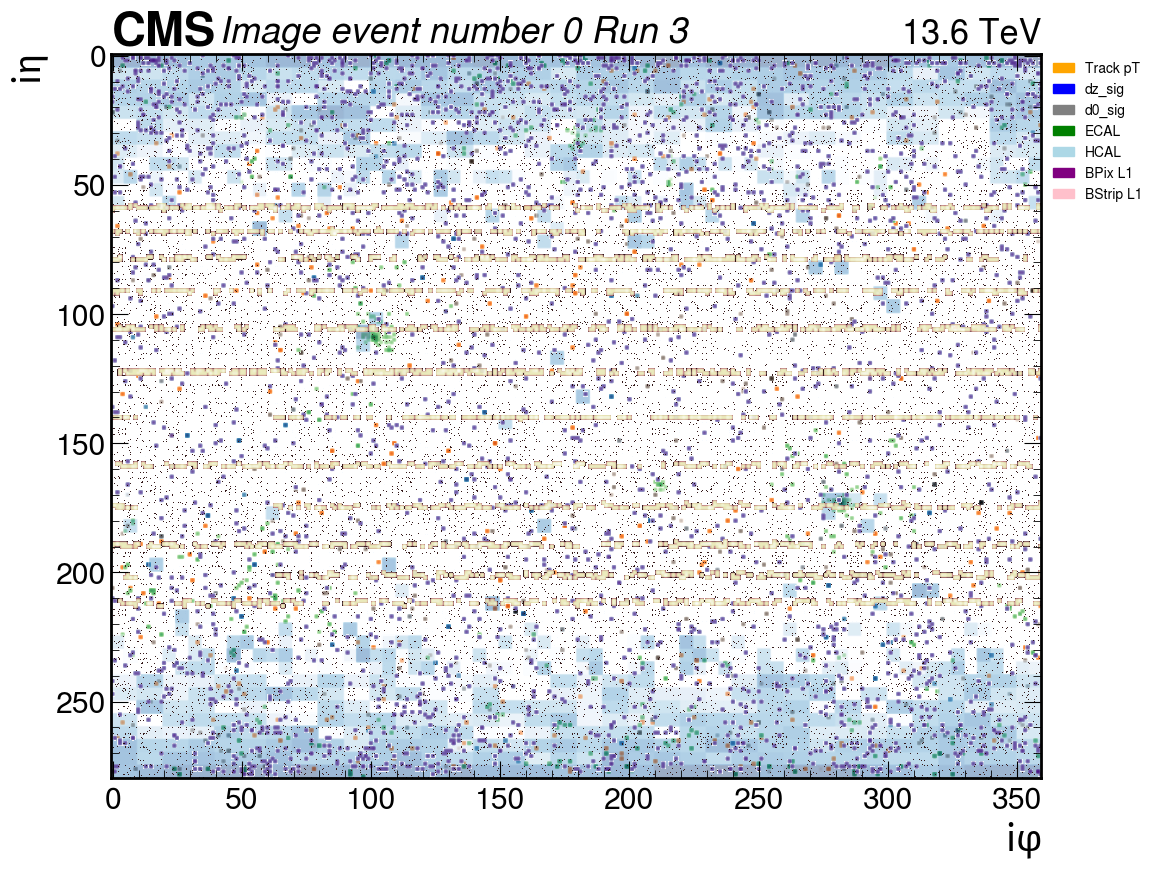

ValueError: in ListOffsetArray64 attempting to get 4, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/libawkward/array/ListOffsetArray.cpp#L682)

In [11]:
# for i in [0,4]:
#        make_img_eve_full(i, 3)

In [13]:
# for i in [4,7]:
#     make_img_eve_cropped(i, 3)

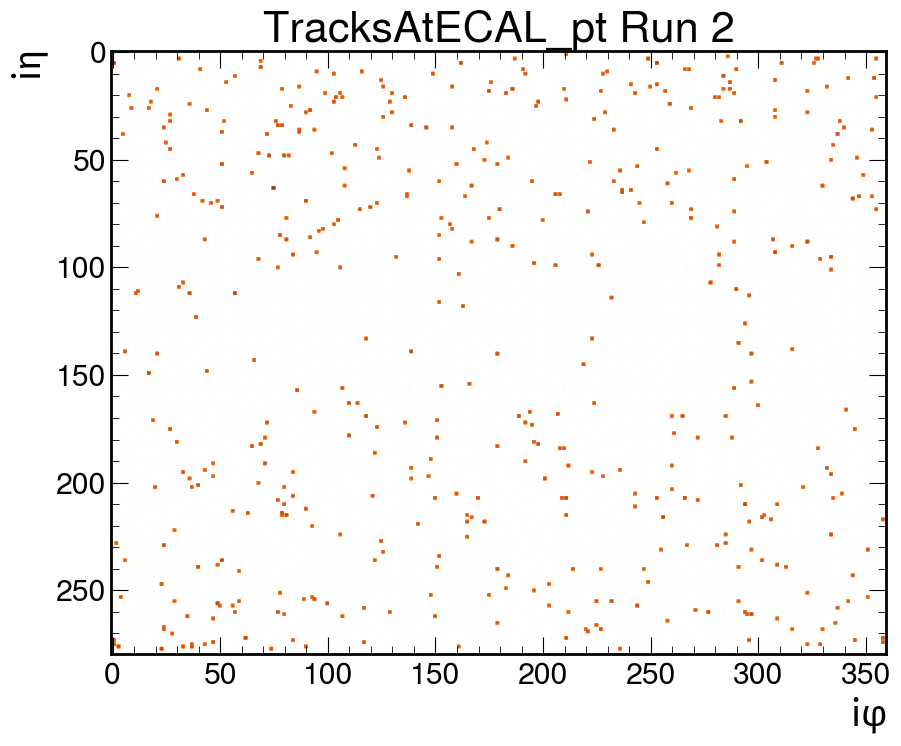

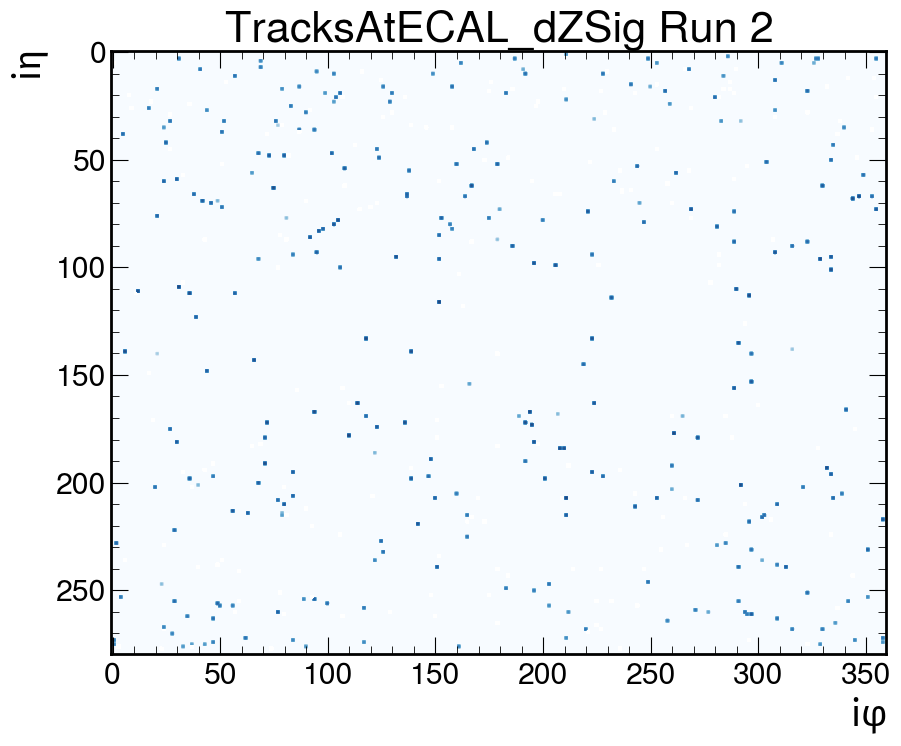

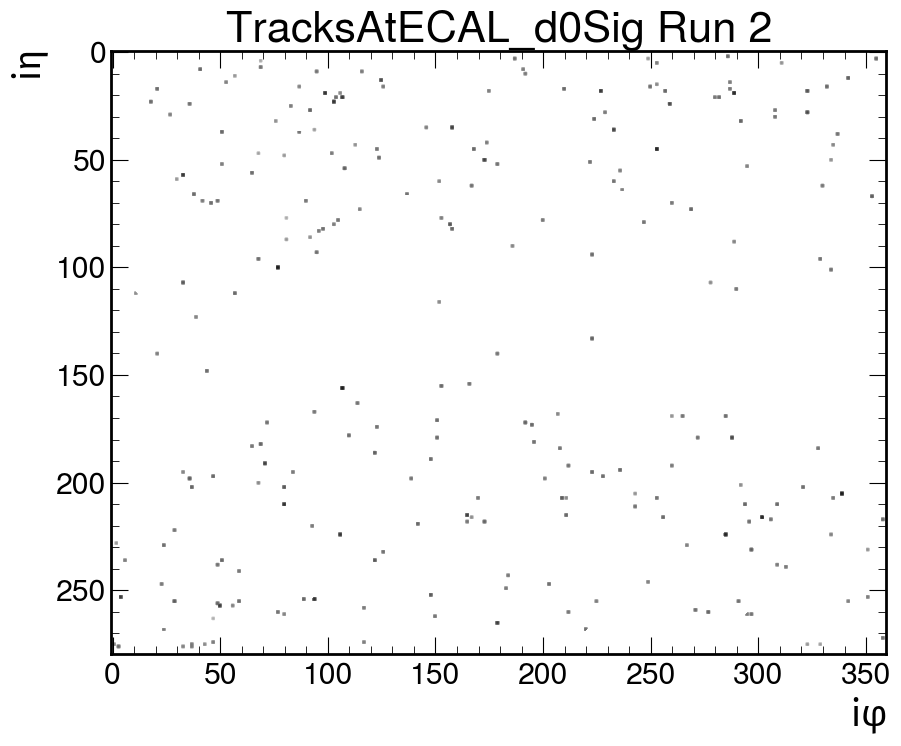

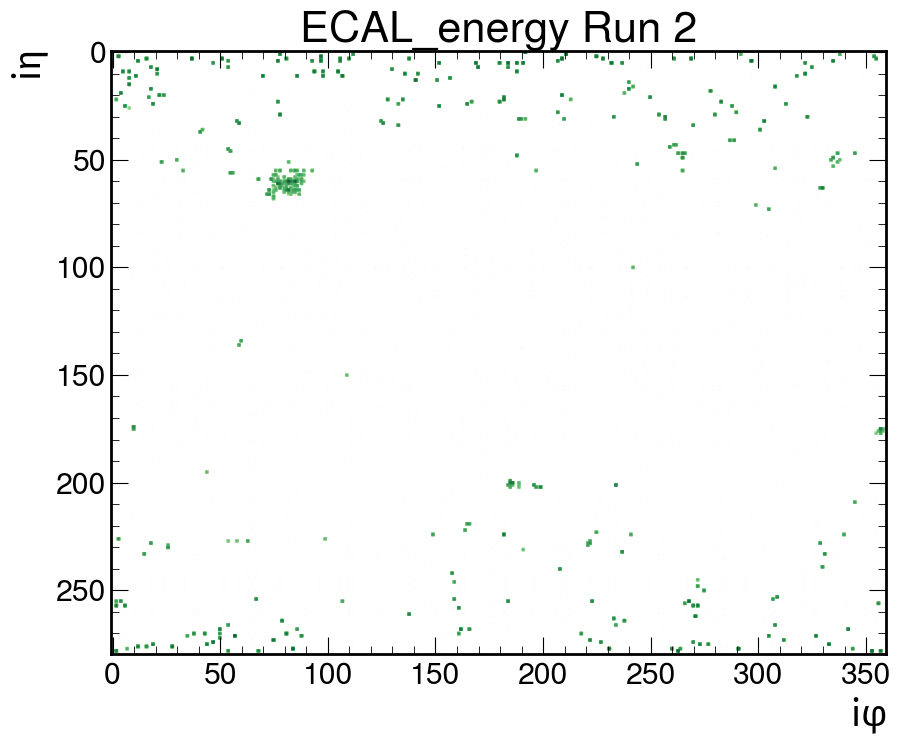

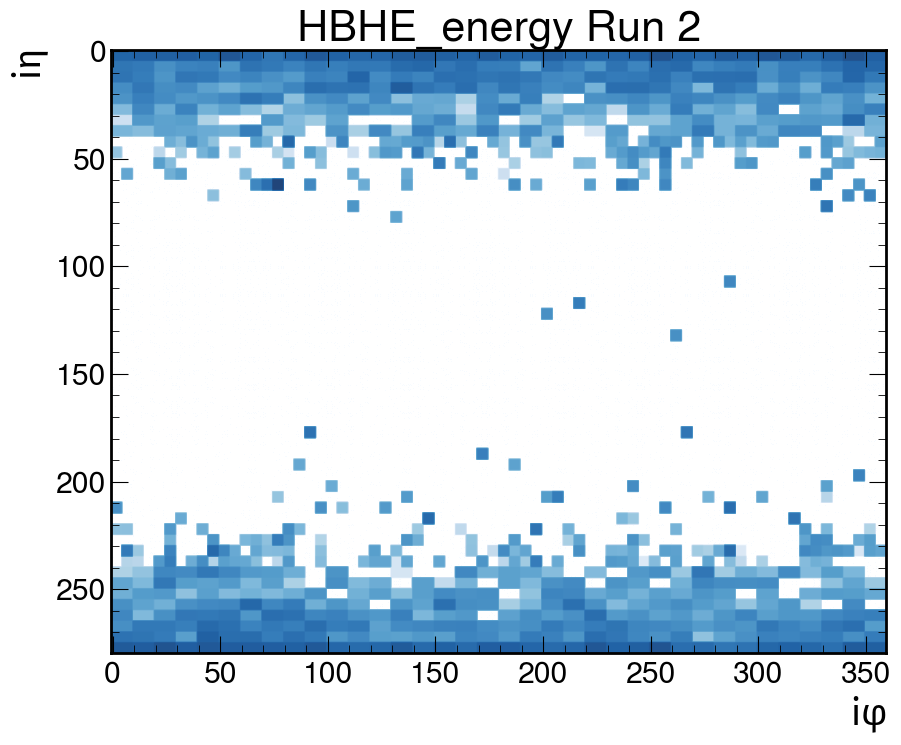

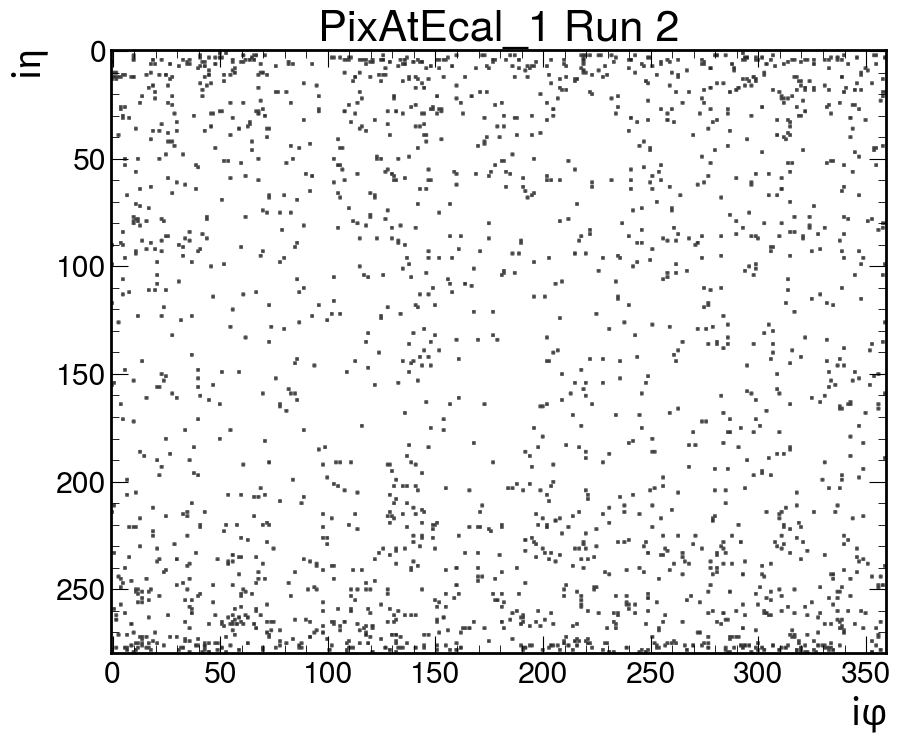

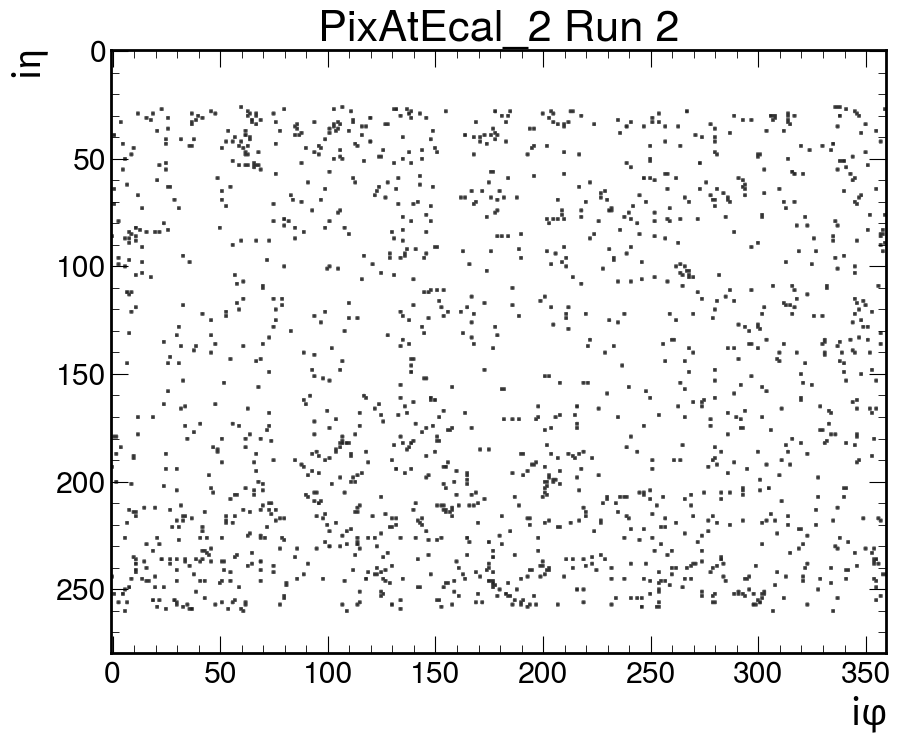

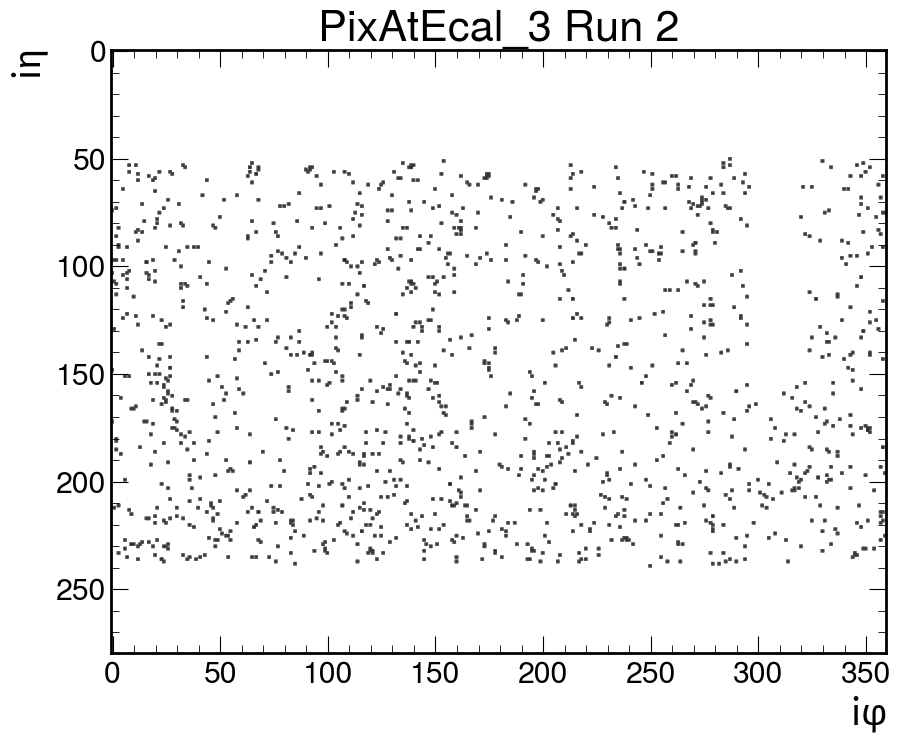

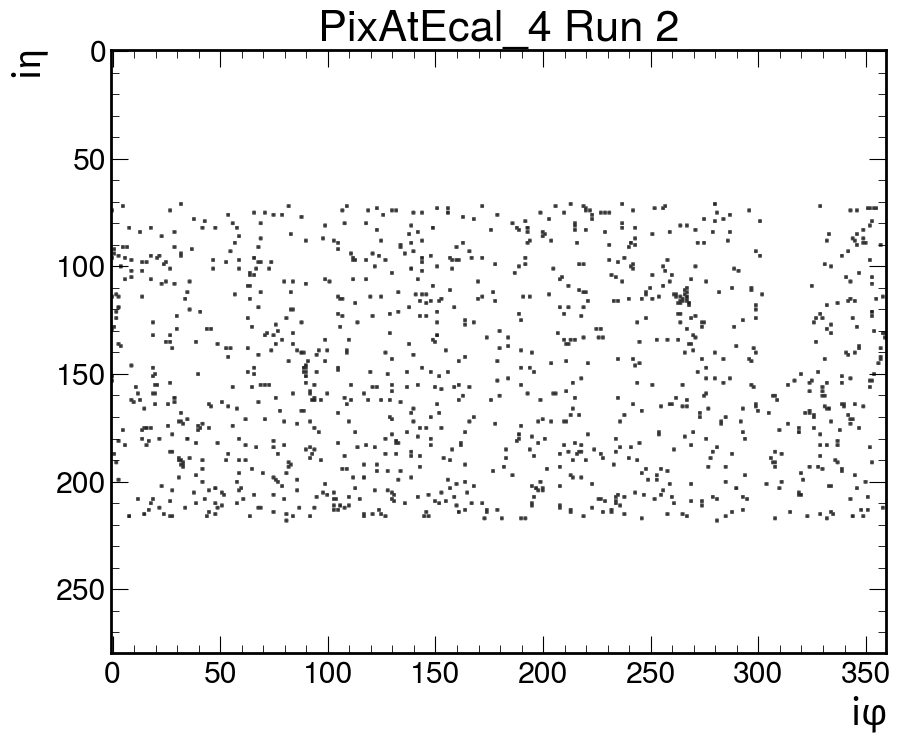

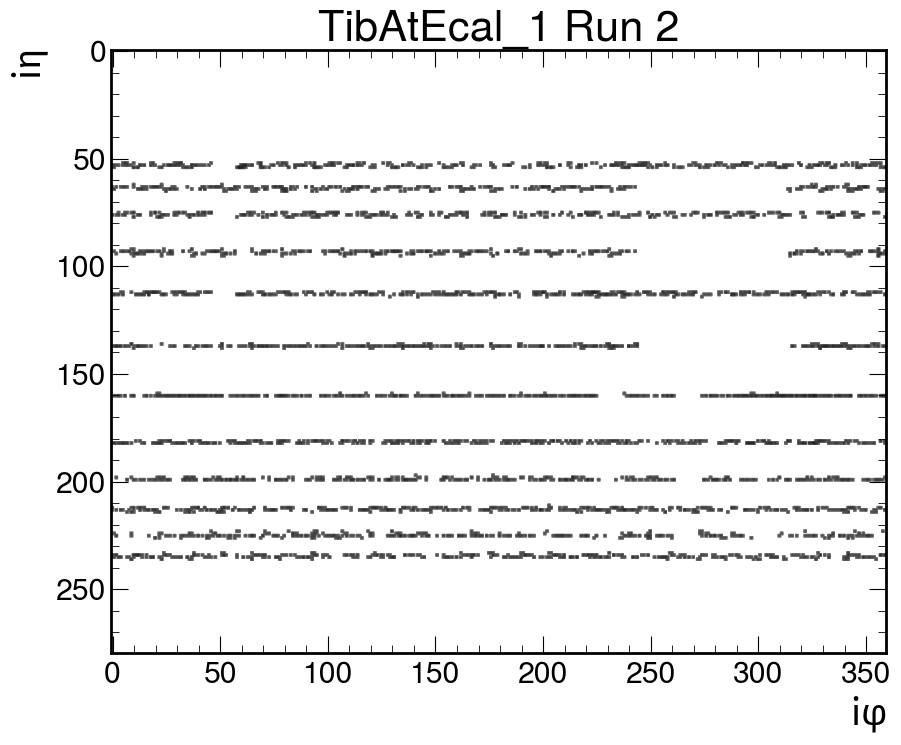

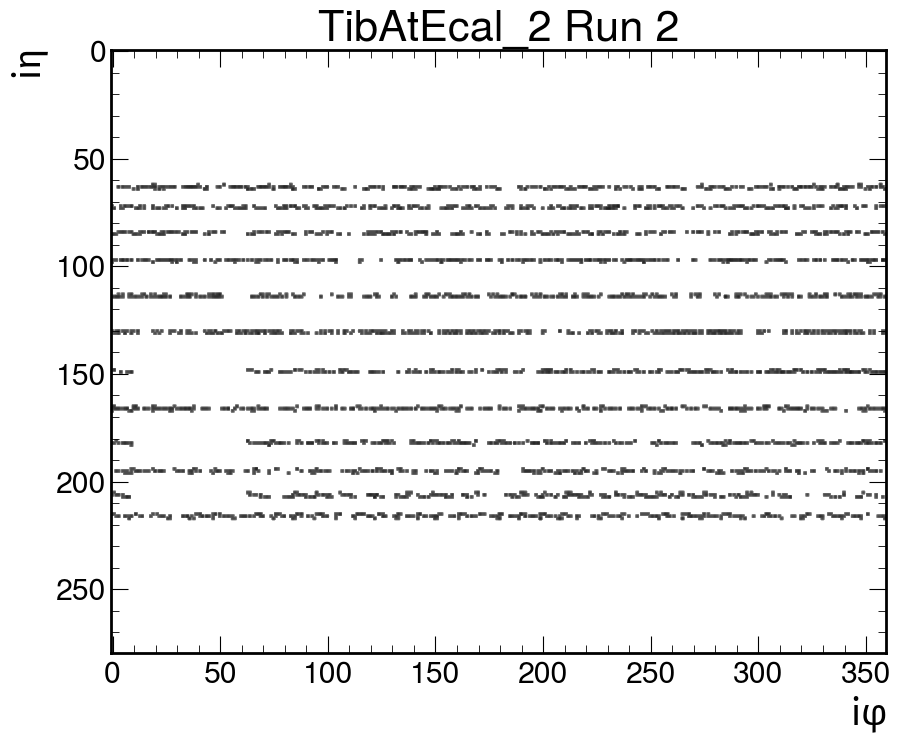

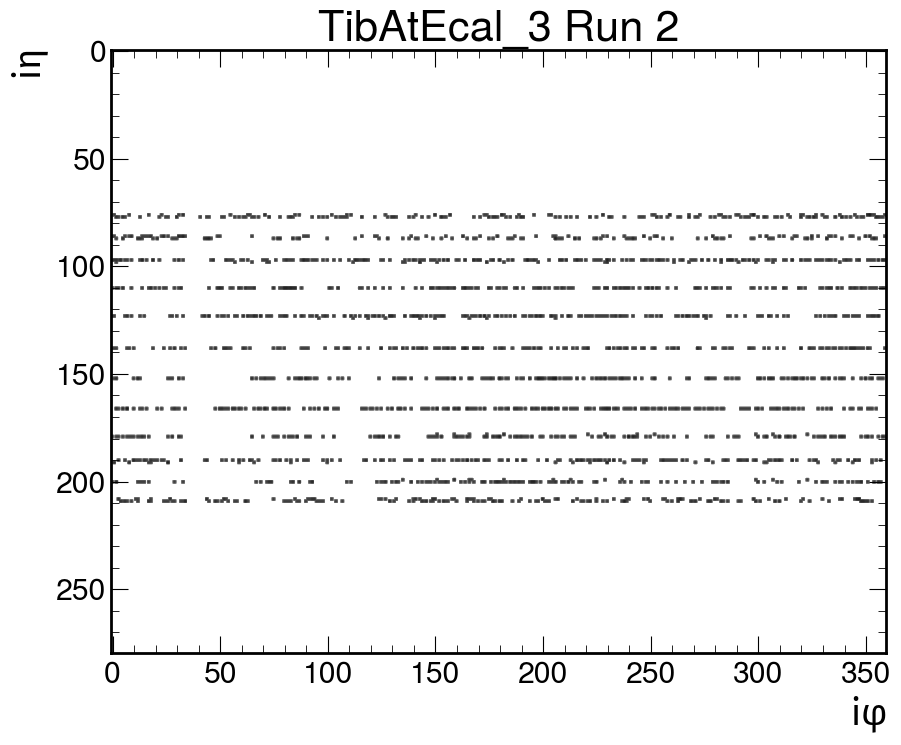

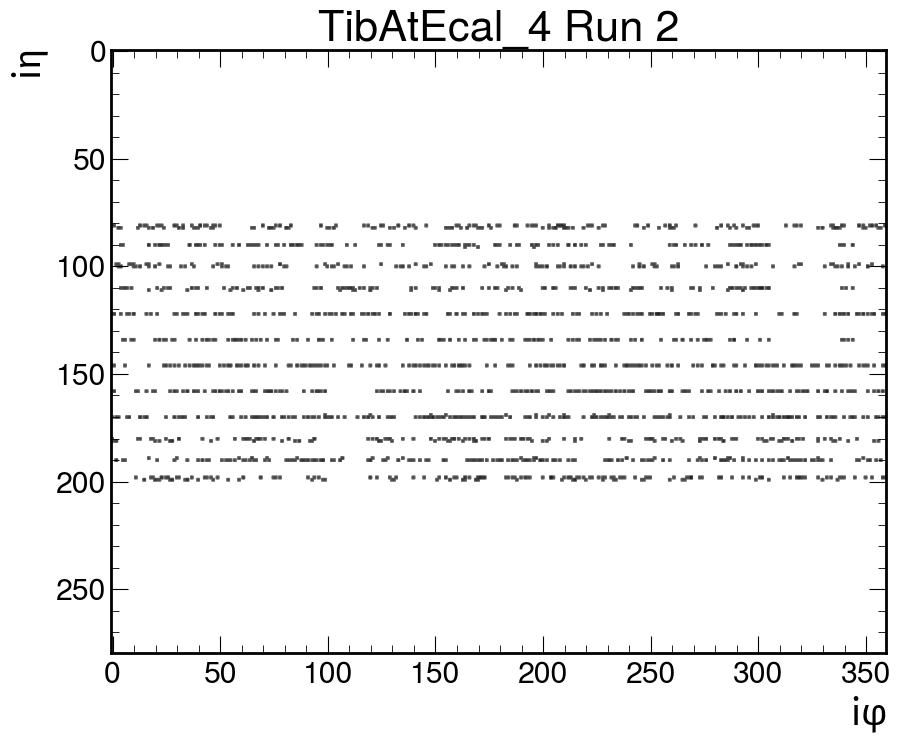

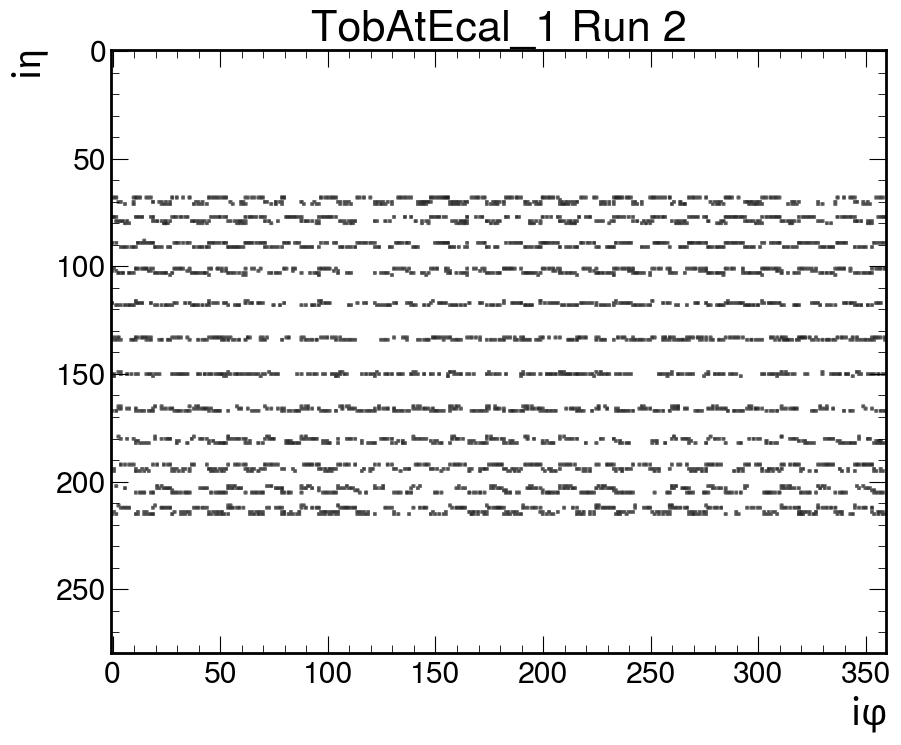

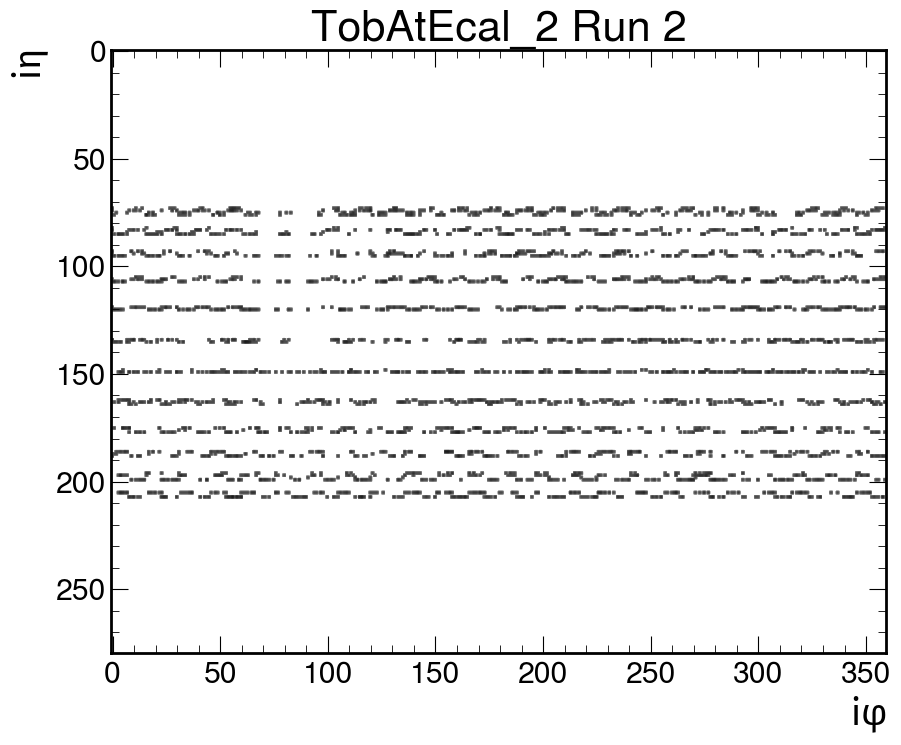

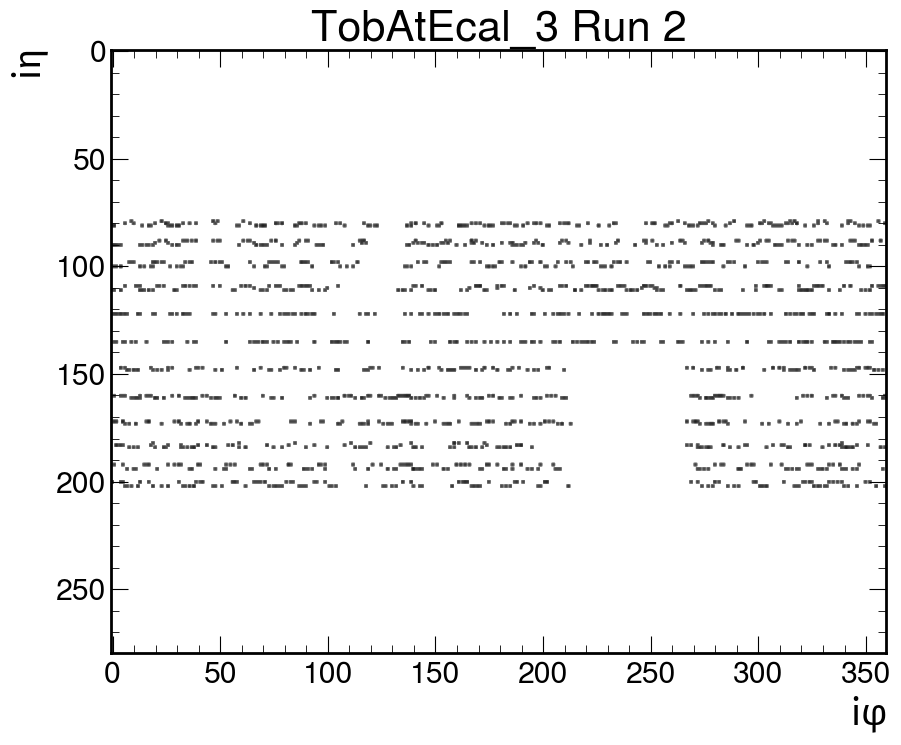

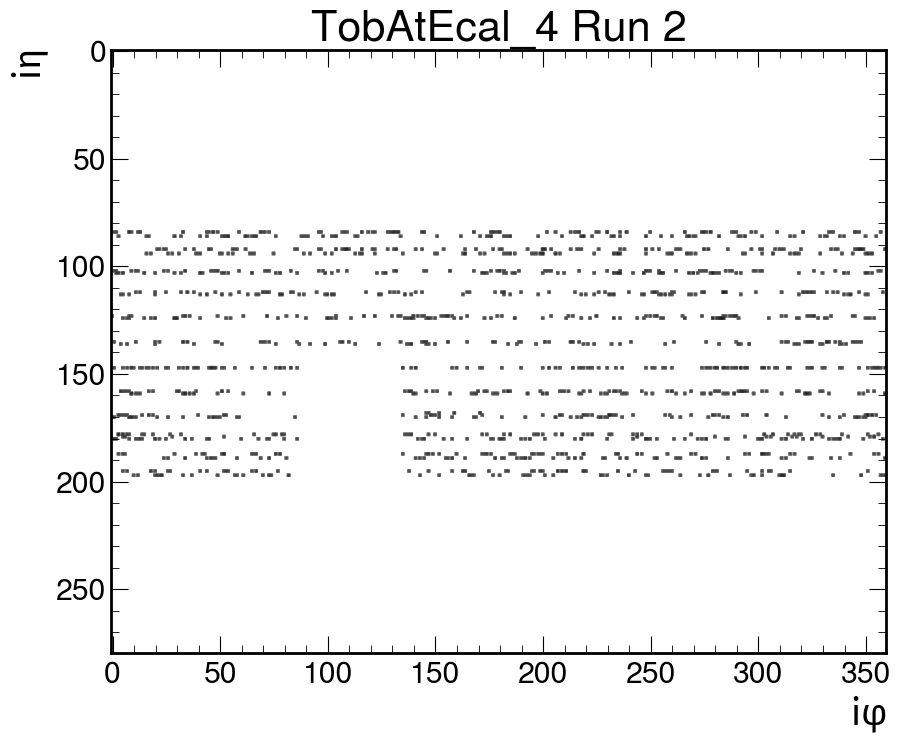

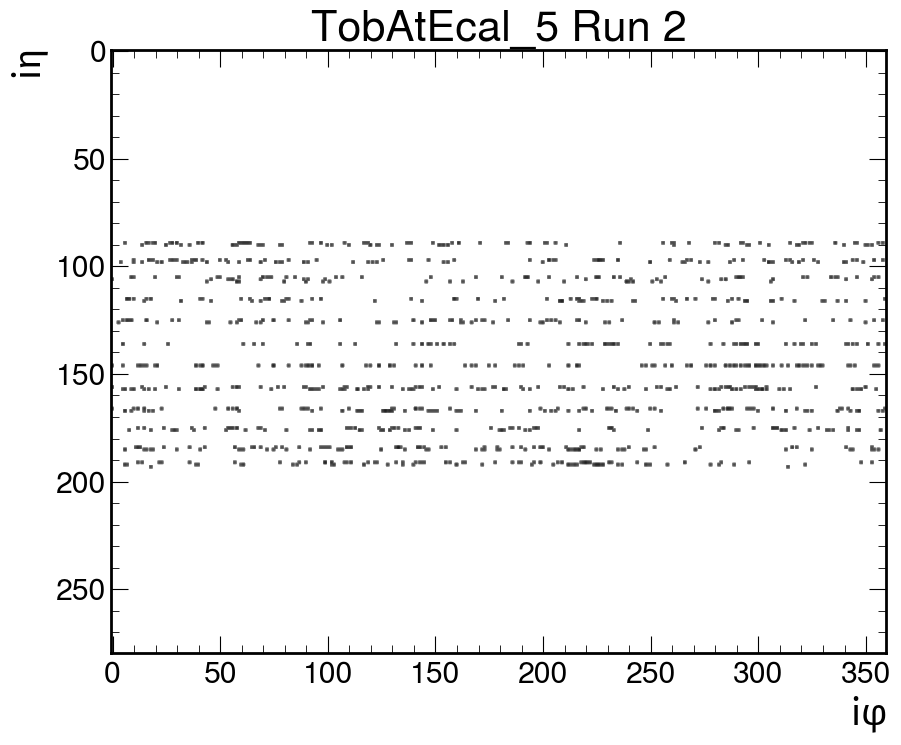

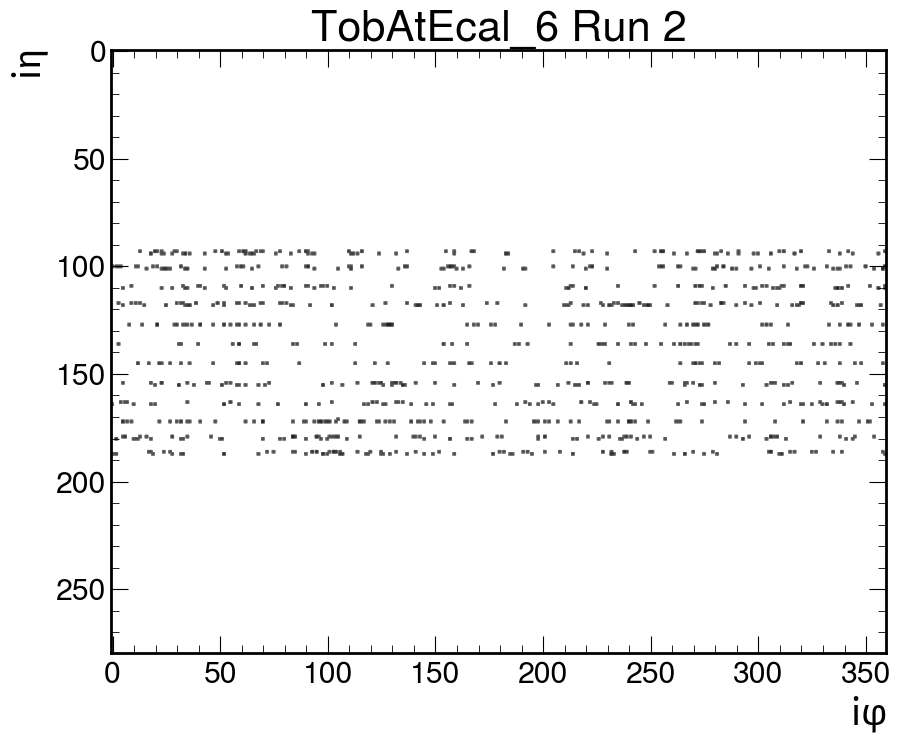

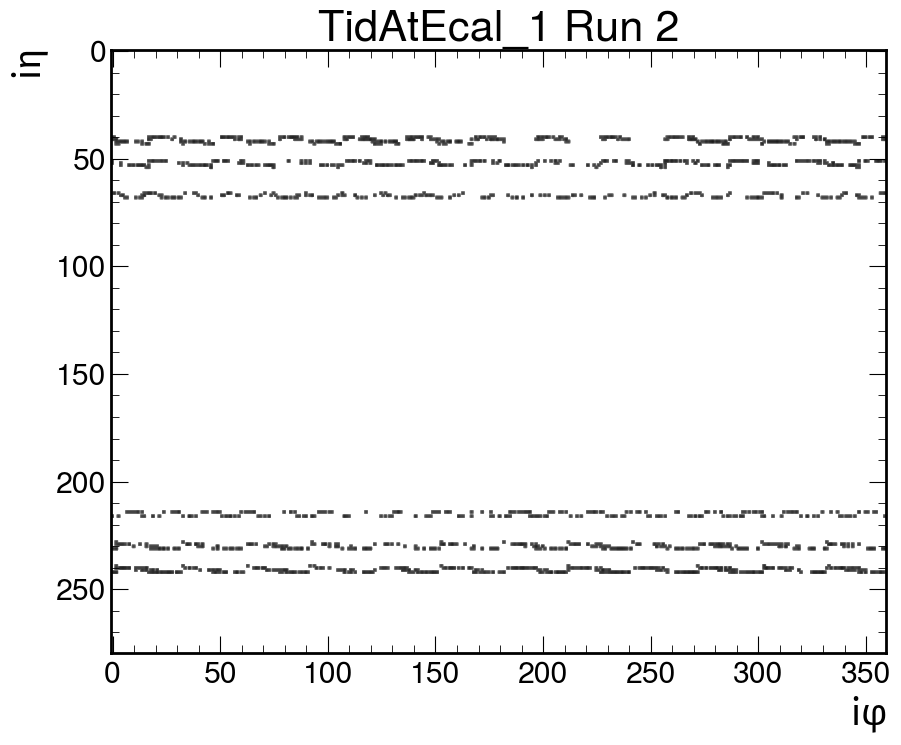

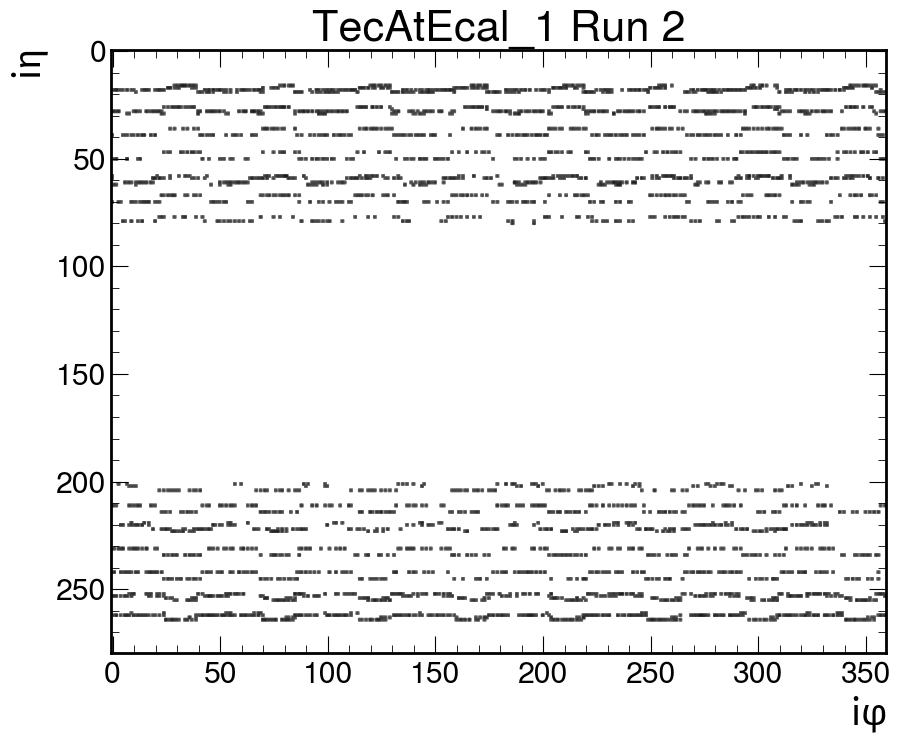

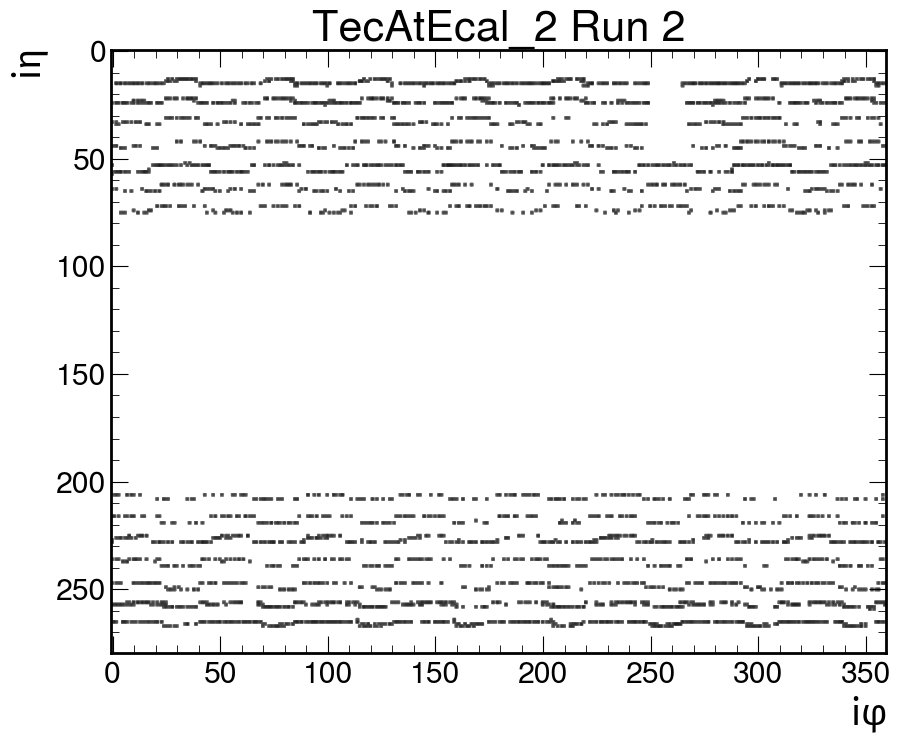

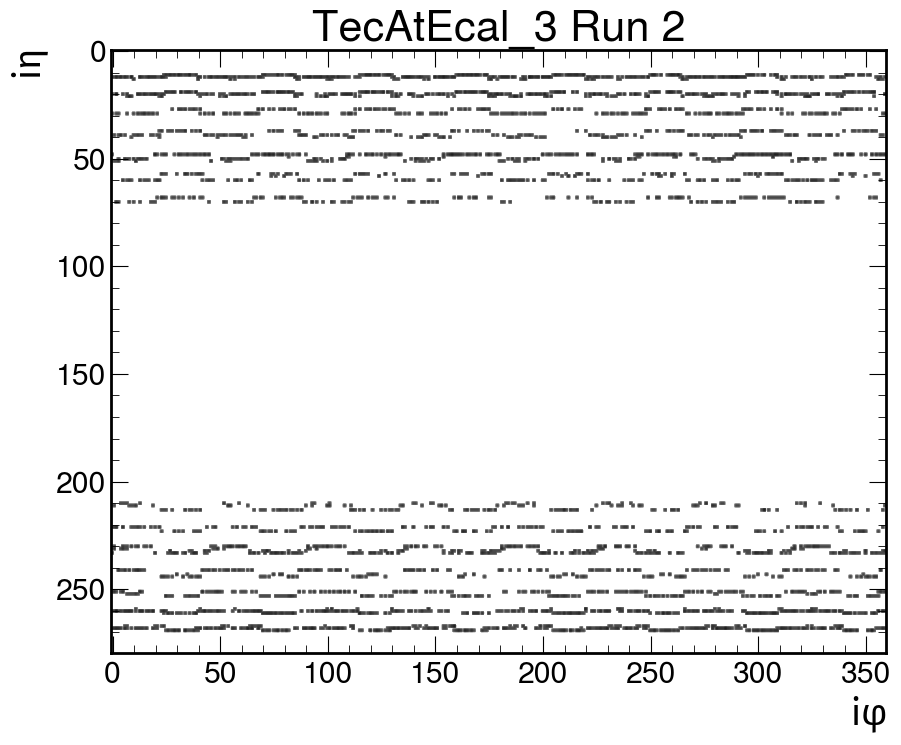

In [14]:
 make_img_all_layers_full(1, 2)

In [11]:
 # make_img_all_layers_cropped(4, 3)